In [2]:
# Coded by Bolin Qin, Center for MRI Research, Peking University, Beijing, China
# Ref: 
# Report on a Multicenter fMRI Quality Assurance Protocol
# Dartmouth fMRI QA: https://www.dartmouth.edu/dbic/research_infrastructure/qualityassurance.html
# Edited on 2023.10.21

In [19]:
from tkinter import Tk, filedialog   # input the QA.nii.gz data 
from scipy.ndimage import uniform_filter  
from matplotlib.patches import Rectangle  # Draw ROI area
import numpy as np
import nibabel as nib
import re
from skimage.filters import threshold_otsu
from skimage.morphology import binary_dilation
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression   # detrend
import math
from scipy.stats import norm  # for normal distribution regression of the time course
import cv2
from reportlab.pdfgen import canvas
from PyPDF2 import PdfMerger
import os
import time

%config InlineBackend.figure_format = 'retina'
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'

plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 20
plt.style.use(['seaborn-bright', 'seaborn-paper'])

In [18]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Generate a GUI to choose QA.nii.gz
def select_data_file():
    root = Tk()
    root.withdraw()
    root.attributes("-topmost", True)
    data_file = filedialog.askopenfilename(title="Select NIfTI data file for analysis",
                                           filetypes=(("NIfTI files", "*.nii.gz;*.nii"),("All files", "*")))
    root.destroy()

    if not data_file:
        raise ValueError("Error: input file not given.")

    return data_file

In [3]:
# Generate a GUI to choose output folder
def select_data_directory():
    root = Tk()
    root.withdraw()
    root.attributes("-topmost", True)
    data_directory = filedialog.askdirectory(title="Select a directory for output results")
    root.destroy()
    if not data_directory:
        raise ValueError("Error: directory not selected.")
    return data_directory

In [4]:
# Get the slice format of the pixel range
def get_pixel_range(center, width):
    ROI_half_start = math.floor(width / 2)
    ROI_half_end = math.ceil(width / 2)
    start = math.floor(center - ROI_half_start)
    end = math.floor(center + ROI_half_end)
    return slice(start, end)

In [5]:
# Detrend the time-series y using matrix X, output the residuals
def detrend_fast(y, X):
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    residual = y - y_pred
    return residual

## 1. Import the QA fMRI data

Format: .nii.gz or .nii

In [20]:
title = "QA fMRI Report"
date = '20231020'
coil_type = 'Nova 8Tx/32Rx Head'

data_file = select_data_file()
basename = re.sub(r"\.nii\.gz$", "", data_file)
basename = re.sub(r"\.nii$", "", basename)
basename = basename.split('/')
basename = basename[-1]

# Output file direction
output_setting = select_data_directory()
output_dir = output_setting+'/'+basename
print('Output folder directory: ',output_setting)
# Read nii.gz: data_nii
data_nii = nib.load(data_file)
print("Reading data  : ", data_file)

# nd.array-form: data(x,y,z,t)
data = data_nii.get_fdata()
data = np.transpose(data,(1,0,2,3))  # data(x,y,z,t)
x_dim,y_dim,z_dim= data.shape[0],data.shape[1],data.shape[2]
N = data.shape[3]  # total number of volumes, 200

# Read resolutions from header of data_nii
header = data_nii.header
resolution = header.get_zooms()
x_pix_dim, y_pix_dim, z_pix_dim = resolution[0],resolution[1],resolution[2]
tr = resolution[3]

# Choose the middle slice, abandon the first skip=2 volumes: data (x,y,z,t) --> data_raw(x,y,t)
slice_num = int(np.ceil(data.shape[2] / 2)-1)
skip = 2  
dyns = N - skip
data_raw = data[:, :, slice_num, skip:N]

# Set ROI width
roi_width = 21

# Print the basic analysis parameters
print("Basic analysis parameters")
print("-------------------------")
print("X,Y matrix       : {} x {}".format(x_dim, y_dim))
print("Slices           : {}".format(z_dim))
print("(X,Y,Z) pix dims : ({:.2f}, {:.2f}, {:.2f}) mm".format(x_pix_dim, y_pix_dim, z_pix_dim))
print("TR               : {:.2f} s".format(tr))
print("Ref Slice Index  : {}".format(slice_num))
print("ROI width        : {}".format(roi_width))
print("Total vols       : {}".format(N))
print("Analysis vols    : {}".format(dyns))

Output folder directory:  E:/Bolin/QA/python-test/20231020_QA_7T_8Tx_Long/Report
Reading data  :  E:/Bolin/QA/python-test/20231020_QA_7T_8Tx_Long/NIFTI/EP2D_BOLD_M3P3_1_5MM_QA2_0008.nii.gz
Basic analysis parameters
-------------------------
X,Y matrix       : 150 x 150
Slices           : 69
(X,Y,Z) pix dims : (1.47, 1.47, 1.73) mm
TR               : 1.16 s
Ref Slice Index  : 34
ROI width        : 21
Total vols       : 200
Analysis vols    : 198


## 2. ROI
Choose the ROI in the center of the phantom to do the analysis.

(150, 150)

(150, 150)

(21, 21)

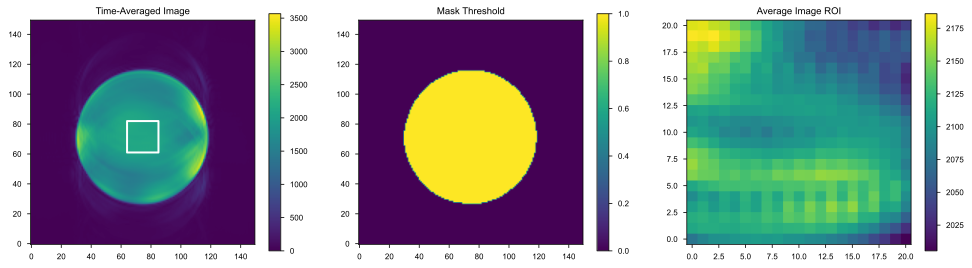

In [22]:
# Average along time: data_raw(x,y,t) --> time_aver_image(x,y)
time_aver_image = np.nanmean(data_raw,axis=2)
display(time_aver_image.shape)

# Threshold to grasp the phantom object: time_aver_image(x,y) --> mask_threshold(x,y) [bool]
mask_threshold = time_aver_image > threshold_otsu(time_aver_image)
# Close calculation kernel with size, in order to fill the holes in the mask
close_kernel_size = 5
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (close_kernel_size, close_kernel_size))  
mask_threshold = cv2.morphologyEx(mask_threshold.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
display(mask_threshold.shape)

# Get the position of Center of Mass
x_pos = round(np.sum(([np.arange(x_dim)]*y_dim)*mask_threshold)/np.sum(mask_threshold))
y_pos = round(np.sum(np.transpose([np.arange(y_dim)] * x_dim) * mask_threshold) / np.sum(mask_threshold))

# Get the slice of x-dim and y-dim in the ROI
ROI_x = get_pixel_range(y_pos, roi_width)
ROI_y = get_pixel_range(x_pos, roi_width)
rect = Rectangle((ROI_y.start, ROI_x.start), roi_width, roi_width, linewidth=2, edgecolor='w', facecolor='none')

# Take the ROI area
time_aver_image_roi = time_aver_image[ROI_x, ROI_y]
display(time_aver_image_roi.shape)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

img_time_aver_image = axes[0].imshow(time_aver_image,origin='lower')
fig.colorbar(img_time_aver_image,ax=axes[0])
axes[0].axis('image')
axes[0].set_title('Time-Averaged Image')
axes[0].add_patch(rect)
# axes[0].add_patch(rect11)

img_mask_threshold = axes[1].imshow(mask_threshold,origin='lower')
fig.colorbar(img_mask_threshold,ax=axes[1])
axes[1].set_title('Mask Threshold')

img_time_aver_image_roi = axes[2].imshow(time_aver_image_roi,origin='lower')
fig.colorbar(img_time_aver_image_roi,ax=axes[2])
axes[2].axis('image')
axes[2].set_title('Average Image ROI')

plt.tight_layout()

## 3. Analysis

### 3.1 Signal Map -- the mean signal across time

The signal image is  average voxel by voxel across the all measurements (TRs).

Mean Signal Intensity =  2106.628759247807


(150, 150)

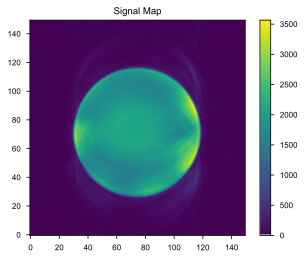

In [24]:
# Signal Image: data_raw(x,y,t) --> time_aver_image(x,y)
time_aver_image = np.nanmean(data_raw,axis=2)
aver_signal = np.mean(time_aver_image[ROI_x, ROI_y])
print('Mean Signal Intensity = ', aver_signal)
display(time_aver_image.shape)

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
img = ax.imshow(time_aver_image,origin='lower')
ax.set_title('Signal Map')
fig.colorbar(img,ax=ax)
plt.tight_layout()

### 3.2 Temporal Fluctuation Noise (TFN) Map -- the standard deviation of the detrended time-series

#### Calculation steps:

(1) Detrend the time-series (data_raw) across the all measurements (TRs) for each voxel with a second-order or third-order polynomial;

(2) Temporal Fluctuation Noise (TFN) = the standard deviation (SD) of the residuals (data_detrend).

(150, 150)

(21, 21)

TFN summary value =  16.589273468181638


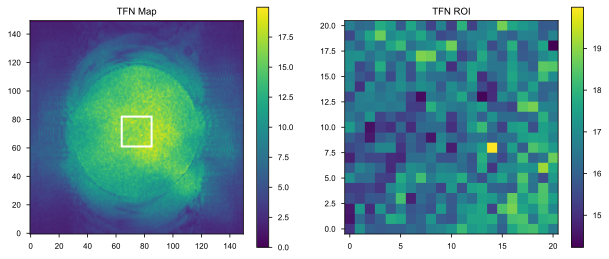

In [25]:
# Set the order of polynomials
poly_det_ord = 3

# Generate a Vandermonde matrix for regression: X, shape=(dyns, poly_det_ord+1)
X = np.vander(np.arange(1, dyns+1), poly_det_ord+1, increasing=True)

# (About 10 s) Detrend time-series using polynomials: data_raw(x,y,t) --> data_detrend(x,y,t)
data_detrend = np.apply_along_axis(detrend_fast, 2, data_raw, X)

# TFN: Temporal Fluctuation Noise, TFN(x,y) = time SD of data_detrend(x,y,t)
TFN_full = np.std(data_detrend, axis=2)
display(TFN_full.shape)

# Draw the ROI area
rect = Rectangle((ROI_y.start, ROI_x.start), roi_width, roi_width, linewidth=2, edgecolor='w', facecolor='none')

# TFN summary value: average the ROI
TFN = TFN_full[ROI_x, ROI_y]
aver_TFN = TFN.mean()
display(TFN.shape)
print('TFN summary value = ',aver_TFN)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

img_TFN_full = axes[0].imshow(TFN_full,origin='lower')
fig.colorbar(img_TFN_full,ax=axes[0])
axes[0].axis('image')
axes[0].set_title('TFN Map')
axes[0].add_patch(rect)

img_TFN = axes[1].imshow(TFN,origin='lower')
fig.colorbar(img_TFN,ax=axes[1])
axes[1].axis('image')
axes[1].set_title('TFN ROI')

plt.tight_layout()

### 3.3 Signal-to-Fluctuation-Noise Ratio (SFNR) Map -- mean signal divided by TFN

SFNR is derived from the ratio of signal and temporal SD maps.

In general, SFNR at 3T is around 200.

Spatial smoothness can be added to image data at the time of reconstruction due to the application of k-space (a.k.a. "apodization") filters.

SFNR increases with increased smoothness, as the Gaussian kernels with full width at half maximum (FWHM) from 1 mm to 15 mm.

$\quad$

#### Calculation steps:

(1) SFNR Image = Signal Image / TFN Image, voxel by voxel

(2) Place a 21 x 21 voxel ROI in the center of the image. The average SFNR across these 441 voxels is the SFNR summary value.


C:\Users\pkucm\AppData\Local\Temp\ipykernel_20156\786210360.py:2: RuntimeWarning: invalid value encountered in divide
  SFNR_full = time_aver_image / TFN_full


(150, 150)

(21, 21)

SFNR summary value =  127.40575121447408


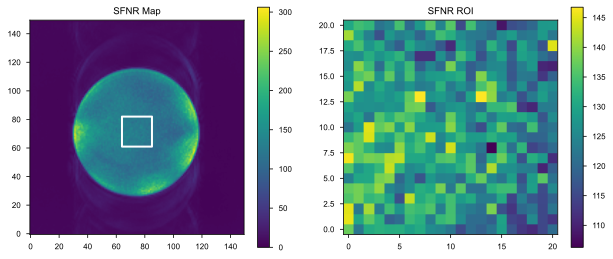

In [26]:
# SFNR: Signal-to-Fluctuation-Noise Ratio
SFNR_full = time_aver_image / TFN_full
SFNR_full = np.nan_to_num(SFNR_full)
display(SFNR_full.shape)

# Draw the ROI area
rect = Rectangle((ROI_y.start, ROI_x.start), roi_width, roi_width, linewidth=2, edgecolor='w', facecolor='none')

# SFNR summary value: average the ROI
SFNR = SFNR_full[ROI_x, ROI_y]
aver_SFNR = SFNR.mean()
display(SFNR.shape)
print('SFNR summary value = ',aver_SFNR)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

img_SFNR_full = axes[0].imshow(SFNR_full,origin='lower')
fig.colorbar(img_SFNR_full,ax=axes[0])
axes[0].axis('image')
axes[0].set_title('SFNR Map')
axes[0].add_patch(rect)

img_SFNR = axes[1].imshow(SFNR,origin='lower')
fig.colorbar(img_SFNR,ax=axes[1])
axes[1].axis('image')
axes[1].set_title('SFNR ROI')

plt.tight_layout()

### 3.4 Temporal Signal-to-Noise Ratio (tSNR) Map

#### Calculation
tSNR = (mean signal over time)/(standard deviation of the signal over time)

tSNR summary value = average tSNR in the ROI

C:\Users\pkucm\AppData\Local\Temp\ipykernel_20156\3386750278.py:3: RuntimeWarning: invalid value encountered in divide
  tSNR_full = time_aver_image / time_sd_image


(150, 150)

(21, 21)

tSNR summary value =  124.277043657469


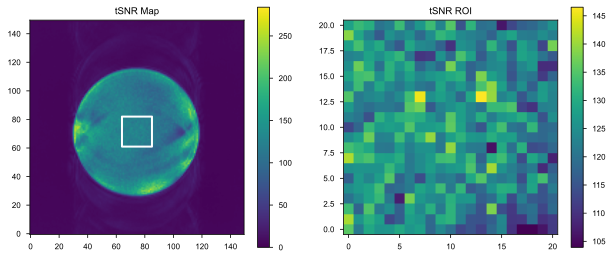

In [27]:
# tSNR: temporal signal-to-noise ratio
time_sd_image = np.std(data_raw, axis=2)
tSNR_full = time_aver_image / time_sd_image
tSNR_full = np.nan_to_num(tSNR_full)
display(tSNR_full.shape)

# Draw the ROI area
rect = Rectangle((ROI_y.start, ROI_x.start), roi_width, roi_width, linewidth=2, edgecolor='w', facecolor='none')

# tSNR summary value: average the ROI
tSNR = tSNR_full[ROI_x, ROI_y]
aver_tSNR = tSNR.mean()
display(tSNR.shape)
print('tSNR summary value = ',aver_tSNR)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

img_tSNR_full = axes[0].imshow(tSNR_full,origin='lower')
fig.colorbar(img_tSNR_full,ax=axes[0])
axes[0].axis('image')
axes[0].set_title('tSNR Map')
axes[0].add_patch(rect)

img_tSNR = axes[1].imshow(tSNR,origin='lower')
fig.colorbar(img_tSNR,ax=axes[1])
axes[1].axis('image')
axes[1].set_title('tSNR ROI')

plt.tight_layout()

### 3.5 Static Spatial Noise (SSN, DIFF) Map -- Odd-Even Difference Static Noise Image summing over time

A measure of the spatial noise.

If the images in the time-series exhibit no drift in amplitude or geometry, the DIFF image will display no structure from the phantom, and the variance in this image will be a measure of the intrinsic noise.

$\quad$

Calculation steps:

(1) Sum all of the odd-numbered images (sumODD image) and separately sum all of the even-numbered images (sumEVEN image);

(2) DIFF = sumODD - sumEVEN, is taken as a raw measure of static spatial noise.

(150, 150)

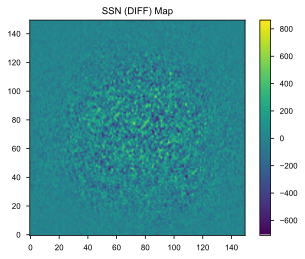

In [28]:
# SSN: Static Spatial Noise 

# Get the odd/even-numbered images (x,y,t)
odd_dynamics = data_raw[:, :, ::2]
even_dynamics = data_raw[:, :, 1::2]

# If odd-numbered images are more than even-numbered images, remove the last odd-numbered image
if odd_dynamics.shape[2] > even_dynamics.shape[2]:
    odd_dynamics = odd_dynamics[:, :, :-1]
    print("Odd number of dynamic scans, removing the last one for the odd-even diff calculation.")

# DIFF(x,y) = sumODD(x,y) - sumEVEN(x,y)
DIFF = np.sum(odd_dynamics, axis=2) - np.sum(even_dynamics, axis=2)
display(DIFF.shape)

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
img = ax.imshow(DIFF,origin='lower')
ax.set_title('SSN (DIFF) Map')
fig.colorbar(img,ax=ax)
plt.tight_layout()

### 3.6 SNR Map -- mean signal divided by standard deviation of DIFF

SNR is derived from the ratio of the mean of an ROI in the time-series signal image and the variance in an ROI in the DIFF image.

Indeed, SNR and SFNR usually provide nearly redundant information. When they differ by more than a few percent, it is because of a low-frequency structure in one of the maps (DIFF, signal, or SD). Such a low-spatial-frequency structure typically results from phase instabilities in either the gradient subsystem (e.g., a noisy gradient amplifier) or any part of the RF subsystem, including the low-power synthesizer / exciter, power amplifier, transmit / receive switch, coil, and receiver.

In general, SNR at 3T is around 200.

SNR increases with increased smoothness in the reconstruction.


$\quad$

#### Calculation steps:

(1) The static spatial noise variance summary value = the variance of the static spatial noise (DIFF) image across a 21 x 21 voxel ROI centered on the image.

(2) The signal summary value = the average of the signal image across the ROI.

(3) SNR = (signal summary value)/sqrt[(variance summary value)/(N - skip)]

SNR summary value =  127.98789192769276


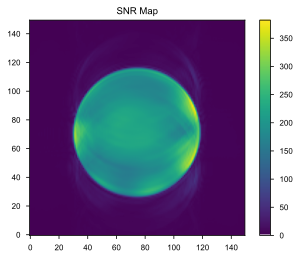

In [29]:
# SNR summary value

# Variance summary value = variance of DIFF_ROI
variance_summary_value = np.std(DIFF[ROI_x, ROI_y]) ** 2

# Signal summary value = average of time_aver_image_ROI
signal_summary_value = np.nanmean(time_aver_image[ROI_x, ROI_y])

# SNR summary value
SNR = signal_summary_value / np.sqrt(variance_summary_value / dyns)
print('SNR summary value = ',SNR)


SNR_full = time_aver_image/np.std(DIFF)*np.sqrt(dyns)
# Plot
fig, ax = plt.subplots(figsize=(5, 4))
img = ax.imshow(SNR_full,origin='lower')
ax.set_title('SNR Map')
fig.colorbar(img,ax=ax)
plt.tight_layout()

### 3.7 Percent Fluctuation -- (SD of the residuals)/(mean signal intensity)
In general, percent fluctuation value of ~0.1% is a typical low level. In the stable scanners, the percent fluctuation is below 0.2%. This is below or comparable to the expected BOLD changes, which can range up to several percent.

### Drift fit = (maximum fit - minimum fit)/(mean signal intensity)
In general, drift value of ~0.4% is good. In the stable scanners, the drift value is below 1.0%. 

### Drift = (maximum raw - minimum raw)/(mean signal intensity)

### Noise distribution

The residuals after the time-series data are detrended should be Gaussian. Deviance from a Gaussian distribution on any one slice or any one volume can indicate scanner instability.

### Calculation steps:

(1) Place the ROI on the data_raw(x,y,t), and calculate the mean signal intensity of the time-series (t);

(2) Fit a second-order polynomial trend to the time-series, and calculate the the standard deviation (SD) of the residuals;

(3) Percent fluctuation = (SD of the residuals)/(mean signal intensity)

(4) Drift = (maximum fit - minimum fit)/(mean signal intensity)


In [30]:
# Percent Fluctuation and Drift

# Get the ROI: dara_raw(x,y,t) --> slice_data_ROI(x,y,t)
slice_data_ROI = data_raw[ROI_x, ROI_y, :]

# Time-series of mean signal intensity(t)
mean_sig_intensity_t = np.mean(slice_data_ROI, axis=(0,1))

# Detrend to get the residuals: mean_sig_intensity_t_detrend(t)
poly_det_ord = 3
X = np.vander(np.arange(1, dyns+1), poly_det_ord+1, increasing=True)
mean_sig_intensity_t_detrend = detrend_fast(mean_sig_intensity_t, X)
# Fit: y_fit(t)
y_fit = mean_sig_intensity_t - mean_sig_intensity_t_detrend

# SD of the residuals: sd_roi
sd_roi = np.std(mean_sig_intensity_t_detrend)
print('STD_roi = ',sd_roi)

# Mean signal intensity
mean_sig_intensity = np.mean(mean_sig_intensity_t)
print('Mean signal intensity = ',mean_sig_intensity)

# Percent Fluctuation
percent_fluc = 100.0 * sd_roi / mean_sig_intensity
print('Percent fluctuation = ',percent_fluc,'%')

# Drift of fit signal
percent_drift_fit = 100.0 * (np.max(y_fit) - np.min(y_fit)) / mean_sig_intensity
print('Drift of fit signal = ',percent_drift_fit,'%')

# Drift of raw signal
percent_drift = 100.0 * (np.max(mean_sig_intensity_t) - np.min(mean_sig_intensity_t)) / mean_sig_intensity
print('Drift of raw signal = ',percent_drift,'%')


STD_roi =  1.6564943070436604
Mean signal intensity =  2106.628759247807
Percent fluctuation =  0.07863247379358518 %
Drift of fit signal =  0.433438291252583 %
Drift of raw signal =  0.6573570450686875 %


198

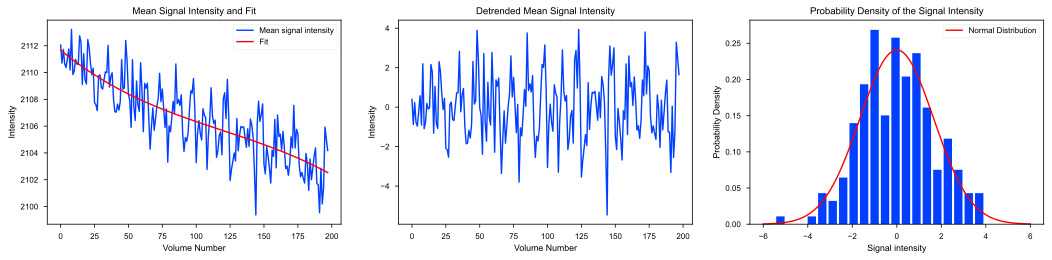

In [31]:
display(len(mean_sig_intensity_t))

# Fit the distribution of residuals to nomal distribution
norm_mu, norm_std = norm.fit(mean_sig_intensity_t_detrend)
norm_halfwidth = max(abs(np.floor(min(mean_sig_intensity_t_detrend))), abs(np.ceil(max(mean_sig_intensity_t_detrend))))
norm_x = np.linspace(-norm_halfwidth,norm_halfwidth, 100)
norm_y = norm.pdf(norm_x, norm_mu, norm_std)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(mean_sig_intensity_t,label='Mean signal intensity')
axes[0].plot(y_fit,color='r',label='Fit')
axes[0].set_xlabel("Volume Number")
axes[0].set_ylabel("Intensity")
axes[0].set_title('Mean Signal Intensity and Fit')
axes[0].legend()

axes[1].plot(mean_sig_intensity_t_detrend)
axes[1].set_xlabel("Volume Number")
axes[1].set_ylabel("Intensity")
axes[1].set_title('Detrended Mean Signal Intensity')

# bins = range(int(min(mean_sig_intensity_t_detrend))-5, int(max(mean_sig_intensity_t_detrend))+5)
bins = 20
axes[2].hist(mean_sig_intensity_t_detrend, bins=bins, rwidth=0.8, density=True)
axes[2].plot(norm_x, norm_y, 'r-', label='Normal Distribution')
axes[2].set_xlabel("Signal intensity")
axes[2].set_ylabel("Probability Density")
axes[2].set_title('Probability Density of the Signal Intensity')
axes[2].legend()

plt.tight_layout()

### 3.8 Fourier Analysis of the Residuals

Specific instability frequencies can provide a clue as to the source. For example, a malfunctioning magnet refrigerator component ("cold head") with excess vibration was identified by the presence of its characteristic cycle period as a peak in the spectrum. Note the obvious presence of the slow oscillation (about 0.003 Hz), which was due to a faulty RF-transmit amplifier.

#### Calculation steps:

(1) Based on a mixed-radix calculation, do the fast Fourier transform of the detrended mean signal intensity time-series, suppressing the DC term.

(2) Calculate Median Absolute Deviation: 

Absolute Deviation = abs(spectrum - (median of spectrum))

MAD = (maximum of spectrum)/(median of Absolute Deviation)

In [32]:
# FFT
spec = np.abs(np.fft.fft(mean_sig_intensity_t_detrend))
freq = np.fft.fftfreq(len(spec), tr)

# Take the positive frequency
spec = spec[:len(spec)//2]
freq = freq[:len(freq)//2]

# MAD, Median Absolute Deviation
max_spec_outlier = np.max(spec) / np.median(np.abs(spec - np.median(spec)))
print('Median Absolute Deviation = ',max_spec_outlier)


Median Absolute Deviation =  18.370407899336428


99

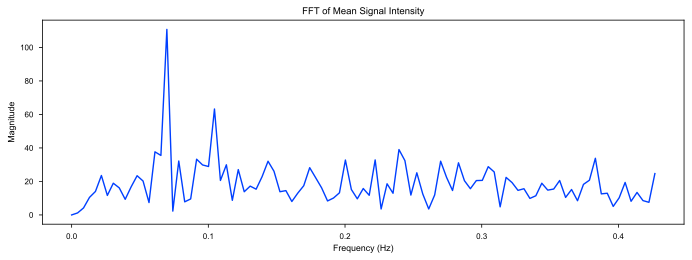

In [33]:
display(len(spec))

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(freq,spec)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
ax.set_title('FFT of Mean Signal Intensity')

plt.tight_layout()

In [34]:
# Find the largest spec and its freq
peak_freq_index = np.argmax(spec)
peak_freq = freq[peak_freq_index]
print('Peak Freq = ',peak_freq,'Hz')

Peak Freq =  0.06966214063216 Hz


### 3.9 Weisskoff Analysis

The Weisskoff analysis assumes that scanner instabilities will impart some increase in the intervoxel correlation, presumably because such instabilities will have some low-spatial-frequency characteristics. 

If there are no such instabilities (or spatial smoothing in the reconstruction), then each voxel is relatively independent of its neighbors, and the coefficient of variation (CV, the standard deviation SD of a time-series divided by the mean of the time-series) for an ROI should scale inversely with the square root of the number of voxels in the ROI.

For a square ROI (roi_width x roi_width), a plot of log(CV) vs. log(N) should follow a declining straight line.

RDC of 13 is good.

#### Calculation steps:

(1) Change the size of ROI: n = 1,2,...,roi_width=21, and get the time-series of the mean signal intensity (t) of each ROI

data_raw(x,y,t) --> slice_data_ROI(x,y,t) --> mean_sig_intensity_t(t)

(2) Detrend the time-series

mean_sig_intensity_t(t) --> mean_sig_intensity_t_dt(t)

(3) Calculate the coefficient of variance value:

CV(n) = (SD of mean_sig_intensity_t_dt)/(mean(mean signal intensity))

(4) Radius of decorrelation

RDC = CV(n=1)/CV(n=roi_width)

(5) Theoretical CV

CV_ideal(n) = CV(n=1)/n


In [35]:
def cal_CV(x_range,y_range):
    # Get ROI: data_raw(x,y,t) --> slice_data_ROI(x,y,t)
    slice_data_ROI = data_raw[x_range, y_range, :]

    # Time-series of mean signal intensity(t)
    mean_sig_intensity_t = np.mean(slice_data_ROI, axis=(0,1))

    # Detrend to get the residuals: mean_sig_intensity_t_dt(t)
    poly_det_ord = 3
    X = np.vander(np.arange(1, dyns+1), poly_det_ord+1, increasing=True)
    mean_sig_intensity_t_dt = np.apply_along_axis(detrend_fast, 0, mean_sig_intensity_t, X)

    # CV = (SD of a time-series)/(mean signal intensity)
    CV_value = np.std(mean_sig_intensity_t_dt) / np.mean(mean_sig_intensity_t)

    return CV_value

In [36]:
# CV: coefficient of variance
CV = np.zeros(roi_width)
CV_ideal = np.zeros(roi_width)

# Iteration for different size of ROI: n=1,2,...,roi_width=21
for n in range(1, roi_width+1):
    # ROI width = n
    x_range = get_pixel_range(y_pos, n)
    y_range = get_pixel_range(x_pos, n)

    # CV
    CV[n-1] = cal_CV(x_range,y_range)

    # CV_ideal = CV[n=1]/n
    CV_ideal[n-1] = CV[0]/n
    
# RDC: Radius of DeCorrelation
RDC = CV[0] / CV[roi_width-1]
print('Radius of DeCorrelation (RDC) = ',RDC)

Radius of DeCorrelation (RDC) =  9.112368046054064


21

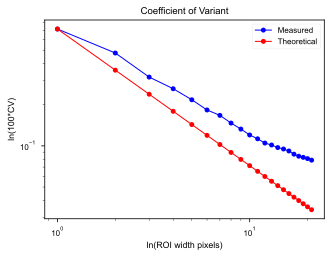

In [37]:
display(len(CV))

roi_list = range(1,roi_width+1)

# Plot
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot(roi_list,CV*100,linewidth=1,marker='.',markersize=10,color='b',label='Measured')
ax.plot(roi_list,CV_ideal*100,linewidth=1,marker='.',markersize=10,color='r',label='Theoretical')
ax.set_xlabel("ln(ROI width pixels)")
ax.set_ylabel("ln(100*CV)")
ax.set_title('Coefficient of Variant')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim((0.01, 10))

plt.tight_layout()

### 3.10 Ghosting


In [38]:
# Dilation to get the original mask
pix_dim = min(x_pix_dim, y_pix_dim)
bg_shrink = 10
original_mask = binary_dilation(mask_threshold, np.ones((round(bg_shrink / pix_dim), round(bg_shrink / pix_dim))))

# Ghost mask
ghost_up=original_mask[:int(x_dim/2),:]
ghost_down=original_mask[int(x_dim/2):,:]
display(ghost_up.shape)
ghost_mask=np.vstack((ghost_down, ghost_up))
display(ghost_mask.shape)

# Mean signal: original=1, ghost=0
signal_no_ghost_mask = original_mask.copy()
signal_no_ghost_mask[ghost_mask]=False
signal_no_ghost = time_aver_image*signal_no_ghost_mask
mean_signal = np.nanmean(signal_no_ghost)
print('Mean signal = ',mean_signal)

# Mean ghost: original=0, ghost=1
ghost_no_signal_mask = ghost_mask.copy()
ghost_no_signal_mask[original_mask]=False
ghost_no_signal = time_aver_image*ghost_no_signal_mask
mean_ghost = np.nanmean(ghost_no_signal)
print('Mean ghost = ',mean_ghost)

ghost_rate=100*mean_ghost/mean_signal
print('Ghost rate = ',ghost_rate,'%')

(75, 150)

(150, 150)

Mean signal =  437.3575019079685
Mean ghost =  14.808386531986534
Ghost rate =  3.385876878156901 %


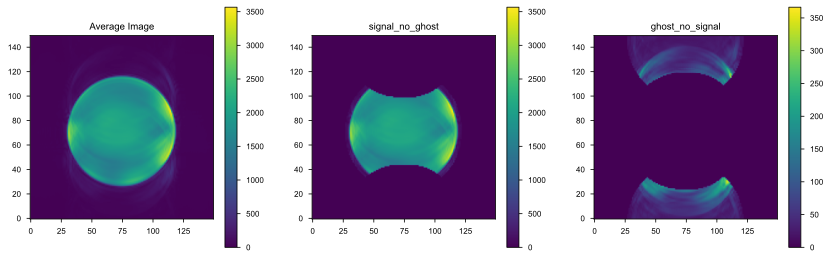

In [39]:
# Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

img_time_aver_image = axes[0].imshow(time_aver_image,origin='lower')
fig.colorbar(img_time_aver_image,ax=axes[0])
axes[0].axis('image')
axes[0].set_title('Average Image')

img_signal_no_ghost = axes[1].imshow(signal_no_ghost,origin='lower')
fig.colorbar(img_signal_no_ghost,ax=axes[1])
axes[1].axis('image')
axes[1].set_title('signal_no_ghost')

img_ghost_no_signal = axes[2].imshow(ghost_no_signal,origin='lower')
fig.colorbar(img_ghost_no_signal,ax=axes[2])
axes[2].axis('image')
axes[2].set_title('ghost_no_signal')

plt.tight_layout()

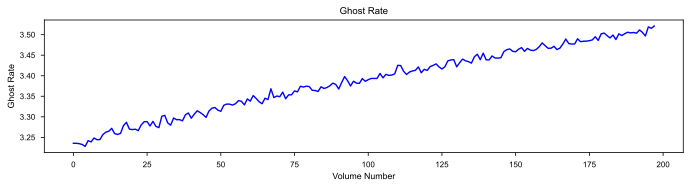

In [40]:
ghost_rate_t = []
for t in range(dyns):
    image_dyns = data_raw[:,:,t]
    signal_dyns = image_dyns*signal_no_ghost_mask
    mean_signal = np.nanmean(signal_dyns)
    ghost_dyns = image_dyns*ghost_no_signal_mask
    mean_ghost = np.nanmean(ghost_dyns)
    ghost_rate_t.append(100*mean_ghost/mean_signal)

# Plot
fig, axes = plt.subplots(figsize=(10, 3))

axes.plot(ghost_rate_t,color='b')
axes.set_xlabel("Volume Number")
axes.set_ylabel("Ghost Rate")
axes.set_title('Ghost Rate')

plt.tight_layout()

### 3.11 Background Noise


In [41]:
background_mask = original_mask.copy()

background_mask[ghost_mask]=True

bg_shrink = 25
background_mask = binary_dilation(background_mask, np.ones((round(bg_shrink / pix_dim), round(bg_shrink / pix_dim))))

background_mask = np.logical_not(background_mask)
background = time_aver_image*background_mask
mean_background = np.nanmean(background)
mean_background_rate = mean_background/mean_signal*100
print('Mean background = ',mean_background)
print('Mean background rate = ',mean_background_rate,'%')

Mean background =  5.662426262626263
Mean background rate =  1.2985781276471684 %


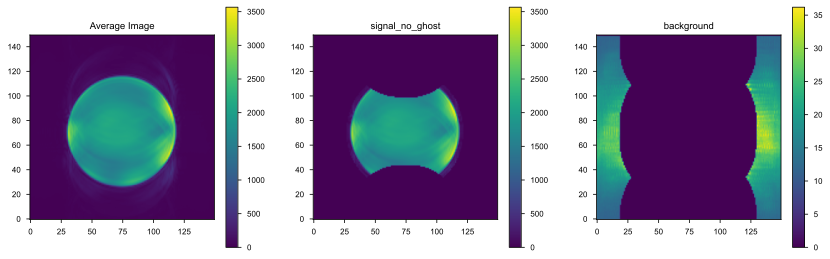

In [42]:
# Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

img_time_aver_image = axes[0].imshow(time_aver_image,origin='lower')
fig.colorbar(img_time_aver_image,ax=axes[0])
axes[0].axis('image')
axes[0].set_title('Average Image')

img_signal_no_ghost = axes[1].imshow(signal_no_ghost,origin='lower')
fig.colorbar(img_signal_no_ghost,ax=axes[1])
axes[1].axis('image')
axes[1].set_title('signal_no_ghost')

img_background = axes[2].imshow(background,origin='lower')
fig.colorbar(img_background,ax=axes[2])
axes[2].axis('image')
axes[2].set_title('background')

plt.tight_layout()

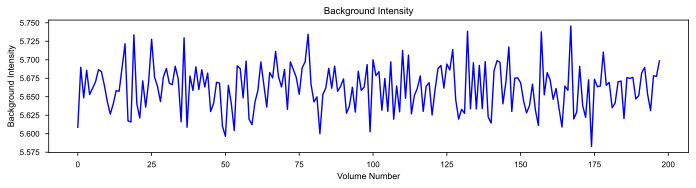

In [43]:
background_t = []
for t in range(dyns):
    image_dyns = data_raw[:,:,t]
    background_dyns = image_dyns*background_mask
    mean_background = np.nanmean(background_dyns)
    background_t.append(mean_background)

# Plot
fig, axes = plt.subplots(figsize=(10, 3))

axes.plot(background_t,color='b')
axes.set_xlabel("Volume Number")
axes.set_ylabel("Background Intensity")
axes.set_title('Background Intensity')

plt.tight_layout()

## Summary Report

In [44]:
# Print the basic analysis parameters
print("Basic analysis parameters")
print("-------------------------")
print("X,Y matrix       : {} x {}".format(x_dim, y_dim))
print("Slices           : {}".format(z_dim))
print("(X,Y,Z) pix dims : ({:.2f}, {:.2f}, {:.2f}) mm".format(x_pix_dim, y_pix_dim, z_pix_dim))
print("TR               : {:.2f} s".format(tr))
print("Ref Slice Num    : {}".format(slice_num))
print("ROI width        : {}".format(roi_width))
print("Total vols       : {}".format(N))
print("Analysis vols    : {}".format(dyns))

Basic analysis parameters
-------------------------
X,Y matrix       : 150 x 150
Slices           : 69
(X,Y,Z) pix dims : (1.47, 1.47, 1.73) mm
TR               : 1.16 s
Ref Slice Num    : 34
ROI width        : 21
Total vols       : 200
Analysis vols    : 198


In [45]:
# Print QA metrics
print("QA metrics")
print("-------------------------")
print("Mean Signal Intensity                    : {:.3f}".format(mean_sig_intensity))
print("Standard Deviation of Detrended Signal   : {:.3f}".format(sd_roi))
print("Percent fluc                             : {:.3f}".format(percent_fluc))
print("Drift                                    : {:.3f}".format(percent_drift))
print("Drift fit                                : {:.3f}".format(percent_drift_fit))
print("SNR                                      : {:.3f}".format(SNR))
print("TFN                                      : {:.3f}".format(aver_TFN))
print("SFNR                                     : {:.3f}".format(aver_SFNR))
print("tSNR                                     : {:.3f}".format(aver_tSNR))
print("RDC                                      : {:.3f}".format(RDC))
print("Spectrum MAD                             : {:.3f}".format(max_spec_outlier))

QA metrics
-------------------------
Mean Signal Intensity                    : 2106.629
Standard Deviation of Detrended Signal   : 1.656
Percent fluc                             : 0.079
Drift                                    : 0.657
Drift fit                                : 0.433
SNR                                      : 127.988
TFN                                      : 16.589
SFNR                                     : 127.406
tSNR                                     : 124.277
RDC                                      : 9.112
Spectrum MAD                             : 18.370


In [52]:
csv_file = output_dir + "_results.csv"
results_tab = pd.DataFrame({
        'Direction': [data_file],
        'Date': [date],
        'Coil': [coil_type],
        'Mean_Signal_Intensity': [mean_sig_intensity],
        'Peak_Freq_Hz': [peak_freq],
        'STD': [sd_roi],
        'SNR': [SNR],
        'TFN': [aver_TFN],
        'SFNR': [aver_SFNR],
        'tSNR': [aver_tSNR],
        'Percent_Fluctuation': [percent_fluc],
        'Drift': [percent_drift],
        'Drift_Fit': [percent_drift_fit],
        'RDC': [RDC],
        'Spectrum_MAD': [max_spec_outlier],
        'Mean_Ghost': [mean_ghost],
        'Ghost_Rate': [ghost_rate],
        'Mean_Background': [mean_background],
        'Background_Rate': [mean_background_rate]
    })
results_tab.to_csv(csv_file, index=False)

In [53]:
text_direction = output_dir + '_text.pdf'

pdf = canvas.Canvas(text_direction)
pdf.setFont("Courier", 10)
pdf_width, pdf_height = pdf._pagesize
title_width = pdf.stringWidth(title, "Courier", 10)
x,y = (pdf_width - title_width)/2, pdf_height - 50
pdf.drawString(x,y, title)
text_content=["",
              "\n Information:",
              "Date   : {}".format(date),
              "Coil   : {}".format(coil_type),
              "",
              "\n Basic analysis parameters:",
              "Matrix Size      : {} x {}".format(x_dim, y_dim),
              "Slices           : {}".format(z_dim),
              "Resolution       : {:.2f} x {:.2f} x {:.2f} mm3".format(x_pix_dim, y_pix_dim, z_pix_dim),
              "TR               : {} ms".format(int(tr*1000)),
              "Ref Slice Num    : {}".format(slice_num),
              "ROI width        : {}".format(roi_width),
              "Total vols       : {}".format(N),
              "Analysis vols    : {}".format(dyns),
              '',
              "\n QA metrics",
              "Mean Signal Intensity      : {:.3f}".format(mean_sig_intensity),
              "Peak Frequency             : {:.4f} Hz".format(peak_freq),
              "STD of Detrended Signal    : {:.3f}".format(sd_roi),
              "SNR                        : {:.3f}".format(SNR),
              "TFN                        : {:.3f}".format(aver_TFN),
              "SFNR                       : {:.3f}".format(aver_SFNR),
              "tSNR                       : {:.3f}".format(aver_tSNR),
              "Percent Fluctuation        : {:.3f} %".format(percent_fluc),
              "Drift                      : {:.3f} %".format(percent_drift),
              "Drift Fit                  : {:.3f} %".format(percent_drift_fit),
              "RDC                        : {:.3f} pixel".format(RDC),
              "Spectrum MAD               : {:.3f}".format(max_spec_outlier),
              "Ghost Rate                 : {:.3f} %".format(ghost_rate),
              "Background Noise Rate      : {:.3f} %".format(mean_background_rate),
              '',
              "\n Notice",
              "DIFF = Difference between Odd-volumes and Even-volumes",
              "SNR = Signal-to-Noise Ratio",
              "    = (mean signal)/(standard deviation of DIFF)",
              "TFN = standard deviation of detrended signal",
              "SFNR = Signal-to-Fluctuation-Noise Ratio",
              "     = (mean signal)/(standard deviation of detrended signal)",
              "tSNR = temporal Signal-to-Noise Ratio",
              "     = (mean signal)/(standard deviation of signal)",
              "Percent Fluctuation = (STD of residuals of 2nd-fit-time-series)/(mean signal)",
              "Drift = (max - min)/(mean signal)",
              "Drift Fit = (maxfit - minfit)/(mean signal)",
              "CV = Coefficient of Variance"
              "RDC = Radius of DeCorrelation, CV(1)/CV(max)",
              "MAD = Median Absolute Deviation = (max)/(median of Absolute Deviation)",
              "Ghost Rate = (mean ghost)/(mean signal)",
              "Background Rate = (mean background)/(mean signal)"
              ]
for text in text_content:
    y = y - 15
    pdf.drawString(80,y, text)
pdf.save()

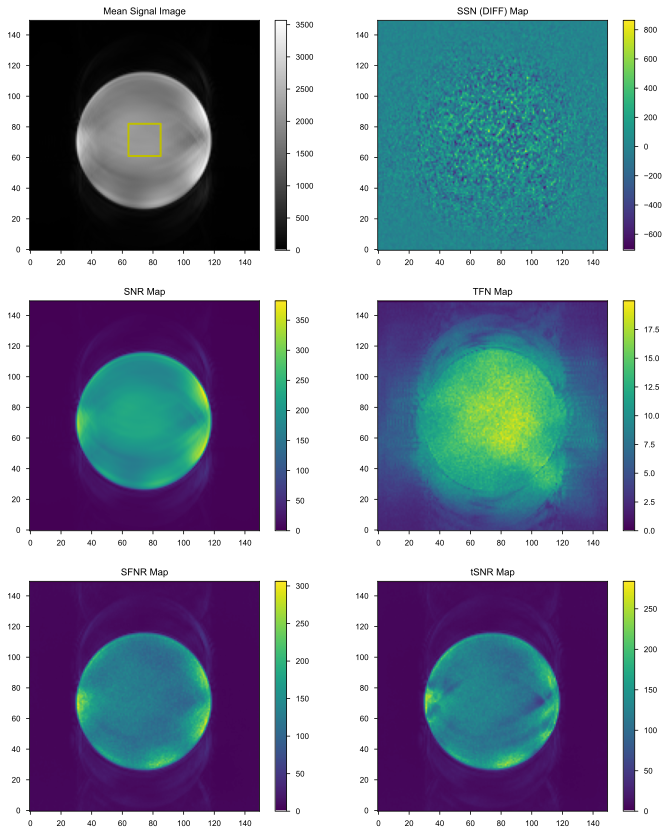

In [54]:
figure1_direction = output_dir + '_map.pdf'

# Plot
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# Mean Signal Image
rect = Rectangle((ROI_y.start, ROI_x.start), roi_width, roi_width, linewidth=2, edgecolor='y', facecolor='none')
img_time_aver_image = axes[0,0].imshow(time_aver_image,origin='lower',cmap='gray')
fig.colorbar(img_time_aver_image,ax=axes[0,0])
axes[0,0].set_title('Mean Signal Image')
axes[0,0].add_patch(rect)

# DIFF
img_DIFF = axes[0,1].imshow(DIFF,origin='lower')
fig.colorbar(img_DIFF,ax=axes[0,1])
axes[0,1].set_title('SSN (DIFF) Map')

# SNR
img_SNR_full = axes[1,0].imshow(SNR_full,origin='lower')
fig.colorbar(img_SNR_full,ax=axes[1,0])
axes[1,0].set_title('SNR Map')

# TFN
img_TFN_full = axes[1,1].imshow(TFN_full,origin='lower')
fig.colorbar(img_TFN_full,ax=axes[1,1])
axes[1,1].set_title('TFN Map')

# SFNR
img_SFNR_full = axes[2,0].imshow(SFNR_full,origin='lower')
fig.colorbar(img_SFNR_full,ax=axes[2,0])
axes[2,0].set_title('SFNR Map')

# tSNR
img_tSNR = axes[2,1].imshow(tSNR_full,origin='lower')
fig.colorbar(img_tSNR,ax=axes[2,1])
axes[2,1].set_title('tSNR Map')

plt.tight_layout()
plt.savefig(figure1_direction)

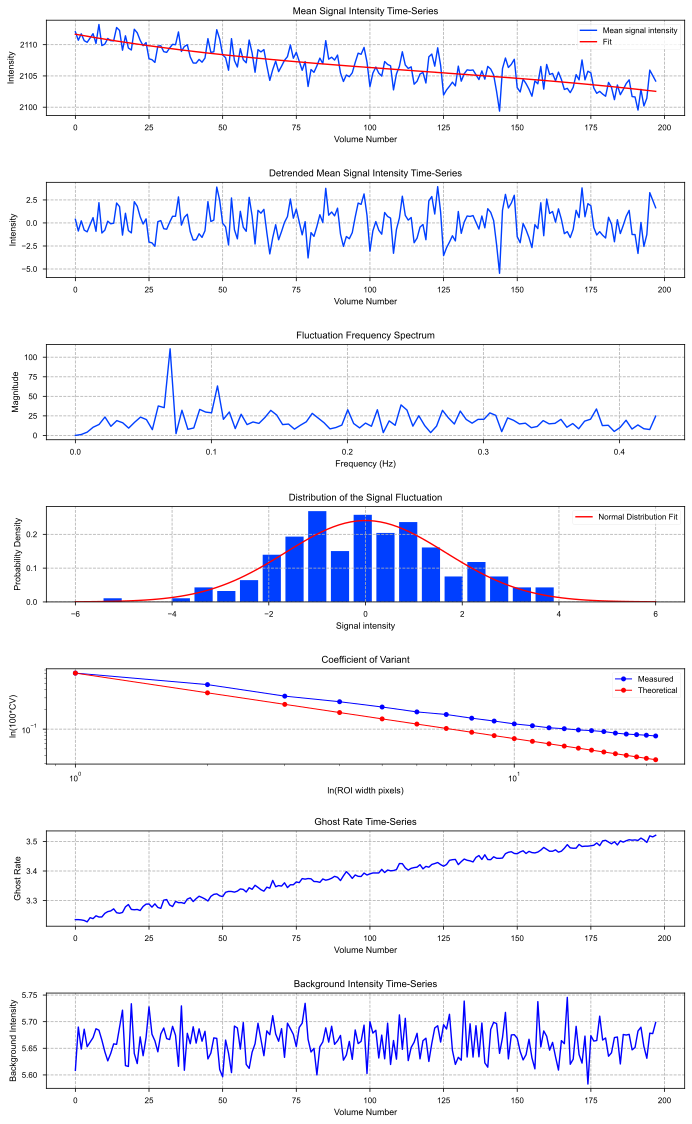

In [55]:
figure2_direction = output_dir + '_plot.pdf'

# Plot
fig, axes = plt.subplots(7,figsize=(10, 16))

axes[0].plot(mean_sig_intensity_t,label='Mean signal intensity')
axes[0].plot(y_fit,color='r',label='Fit')
axes[0].set_xlabel("Volume Number")
axes[0].set_ylabel("Intensity")
axes[0].set_title('Mean Signal Intensity Time-Series')
axes[0].legend()
axes[0].grid(True, linestyle='--')

axes[1].plot(mean_sig_intensity_t_detrend)
axes[1].set_xlabel("Volume Number")
axes[1].set_ylabel("Intensity")
axes[1].set_title('Detrended Mean Signal Intensity Time-Series')
axes[1].grid(True, linestyle='--')

axes[2].plot(freq,spec)
axes[2].set_xlabel("Frequency (Hz)")
axes[2].set_ylabel("Magnitude")
axes[2].set_title('Fluctuation Frequency Spectrum')
axes[2].grid(True, linestyle='--')

bins = 20
axes[3].hist(mean_sig_intensity_t_detrend, bins=bins, rwidth=0.8, density=True)
axes[3].plot(norm_x, norm_y, 'r-', label='Normal Distribution Fit')
axes[3].set_xlabel("Signal intensity")
axes[3].set_ylabel("Probability Density")
axes[3].set_title('Distribution of the Signal Fluctuation')
axes[3].legend()
axes[3].grid(True, linestyle='--')

axes[4].plot(roi_list,CV*100,linewidth=1,marker='.',markersize=10,color='b',label='Measured')
axes[4].plot(roi_list,CV_ideal*100,linewidth=1,marker='.',markersize=10,color='r',label='Theoretical')
axes[4].set_xlabel("ln(ROI width pixels)")
axes[4].set_ylabel("ln(100*CV)")
axes[4].set_title('Coefficient of Variant')
axes[4].legend()
axes[4].set_yscale('log')
axes[4].set_xscale('log')
axes[4].grid(True, linestyle='--')

axes[5].plot(ghost_rate_t,color='b')
axes[5].set_xlabel("Volume Number")
axes[5].set_ylabel("Ghost Rate")
axes[5].set_title('Ghost Rate Time-Series')
axes[5].grid(True, linestyle='--')

axes[6].plot(background_t,color='b')
axes[6].set_xlabel("Volume Number")
axes[6].set_ylabel("Background Intensity")
axes[6].set_title('Background Intensity Time-Series')
axes[6].grid(True, linestyle='--')

plt.tight_layout()
plt.savefig(figure2_direction)

In [56]:
output_direction = output_dir + '_Report.pdf'
pdf_files = [text_direction, figure1_direction, figure2_direction]

merger = PdfMerger()
for file in pdf_files:
    merger.append(file)
with open(output_direction, "wb") as output_file:
    merger.write(output_file)
    merger.close()

# Delete the useless pdf files
for file in pdf_files:
    os.unlink(file)
